In [1]:
from numpy.random import normal
from numpy.random import randn
import numpy as np
import math
from math import sqrt
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from numpy.linalg import inv
import seaborn as sns

In [2]:
seed = 43

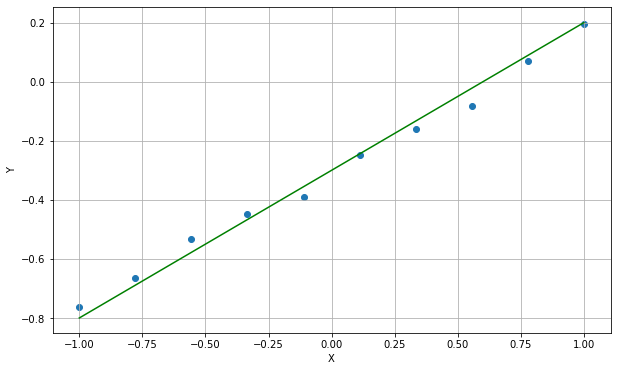

In [3]:
w0 = -0.3
w1 = 0.5
noise_mean = 0
noise_dev = 0.04
n = 10

plt.figure(figsize=(10, 6))
noise_std_dev = math.sqrt(noise_dev)
noise = np.random.normal(0, .04, [1, n])
X = np.linspace(-1, 1, n)
Y = w0 + w1*X + noise[0]
plt.scatter(X, Y)
plt.plot(X, w0 + w1*X, color = 'green')
plt.xlabel("X")
plt.ylabel("Y")
plt.savefig("10_sample_points.png")
plt.grid()

In [4]:
def calc_gaussian(x,mean,variance):
  sigma=sqrt(variance)
  y=(1/(sigma*sqrt(2*np.pi)))*((np.exp([1])[0])**(-0.5*(((x-mean)/sigma)**2)))
  return y



def prior_calc(w1_ax, w0_ax, n):
    prior_mesh = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
             prior_mesh[i][j] = multivariate_normal.pdf([w0_ax[j], w1_ax[i]], mean=[0,0], cov=[[0.5,0],[0,0.5]])
    return prior_mesh


def likelihood_calc(w0_ax, w1_ax, n, x, y):
    likelihood_mesh=np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            calc_g=calc_gaussian(y,w0_ax[j]+w1_ax[i]*x,0.04)
            likelihood_mesh[i][j]=calc_g
    return likelihood_mesh



def posterior_calc(likelihood_mesh, prior_mesh):
    posterior_mesh = likelihood_mesh*prior_mesh
    return posterior_mesh

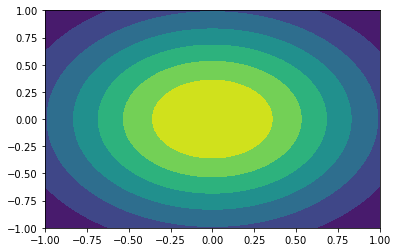

In [5]:
prior_mean = 0
prior_var = 0.5
n = 50

w0_ax = np.linspace(-1, 1, n)
w1_ax = np.linspace(-1, 1, n)

prior_std_dev = math.sqrt(prior_var)
prior_mesh = prior_calc(w1_ax, w0_ax, n)
plt.contourf(w0_ax, w1_ax, prior_mesh)
plt.show()

In [6]:
def posterior_mean_cov(m0, s0, phi, beta, t):
    phi = np.array(phi).reshape(1, 2)
    sn = inv(inv(s0) + beta*(np.transpose(phi)@phi))
    m0 = np.array(m0).reshape(2, 1)
    t = [t]
    mn = sn@(inv(s0)@m0 + beta*(np.transpose(phi).reshape(2, 1)@t))
    return mn,sn

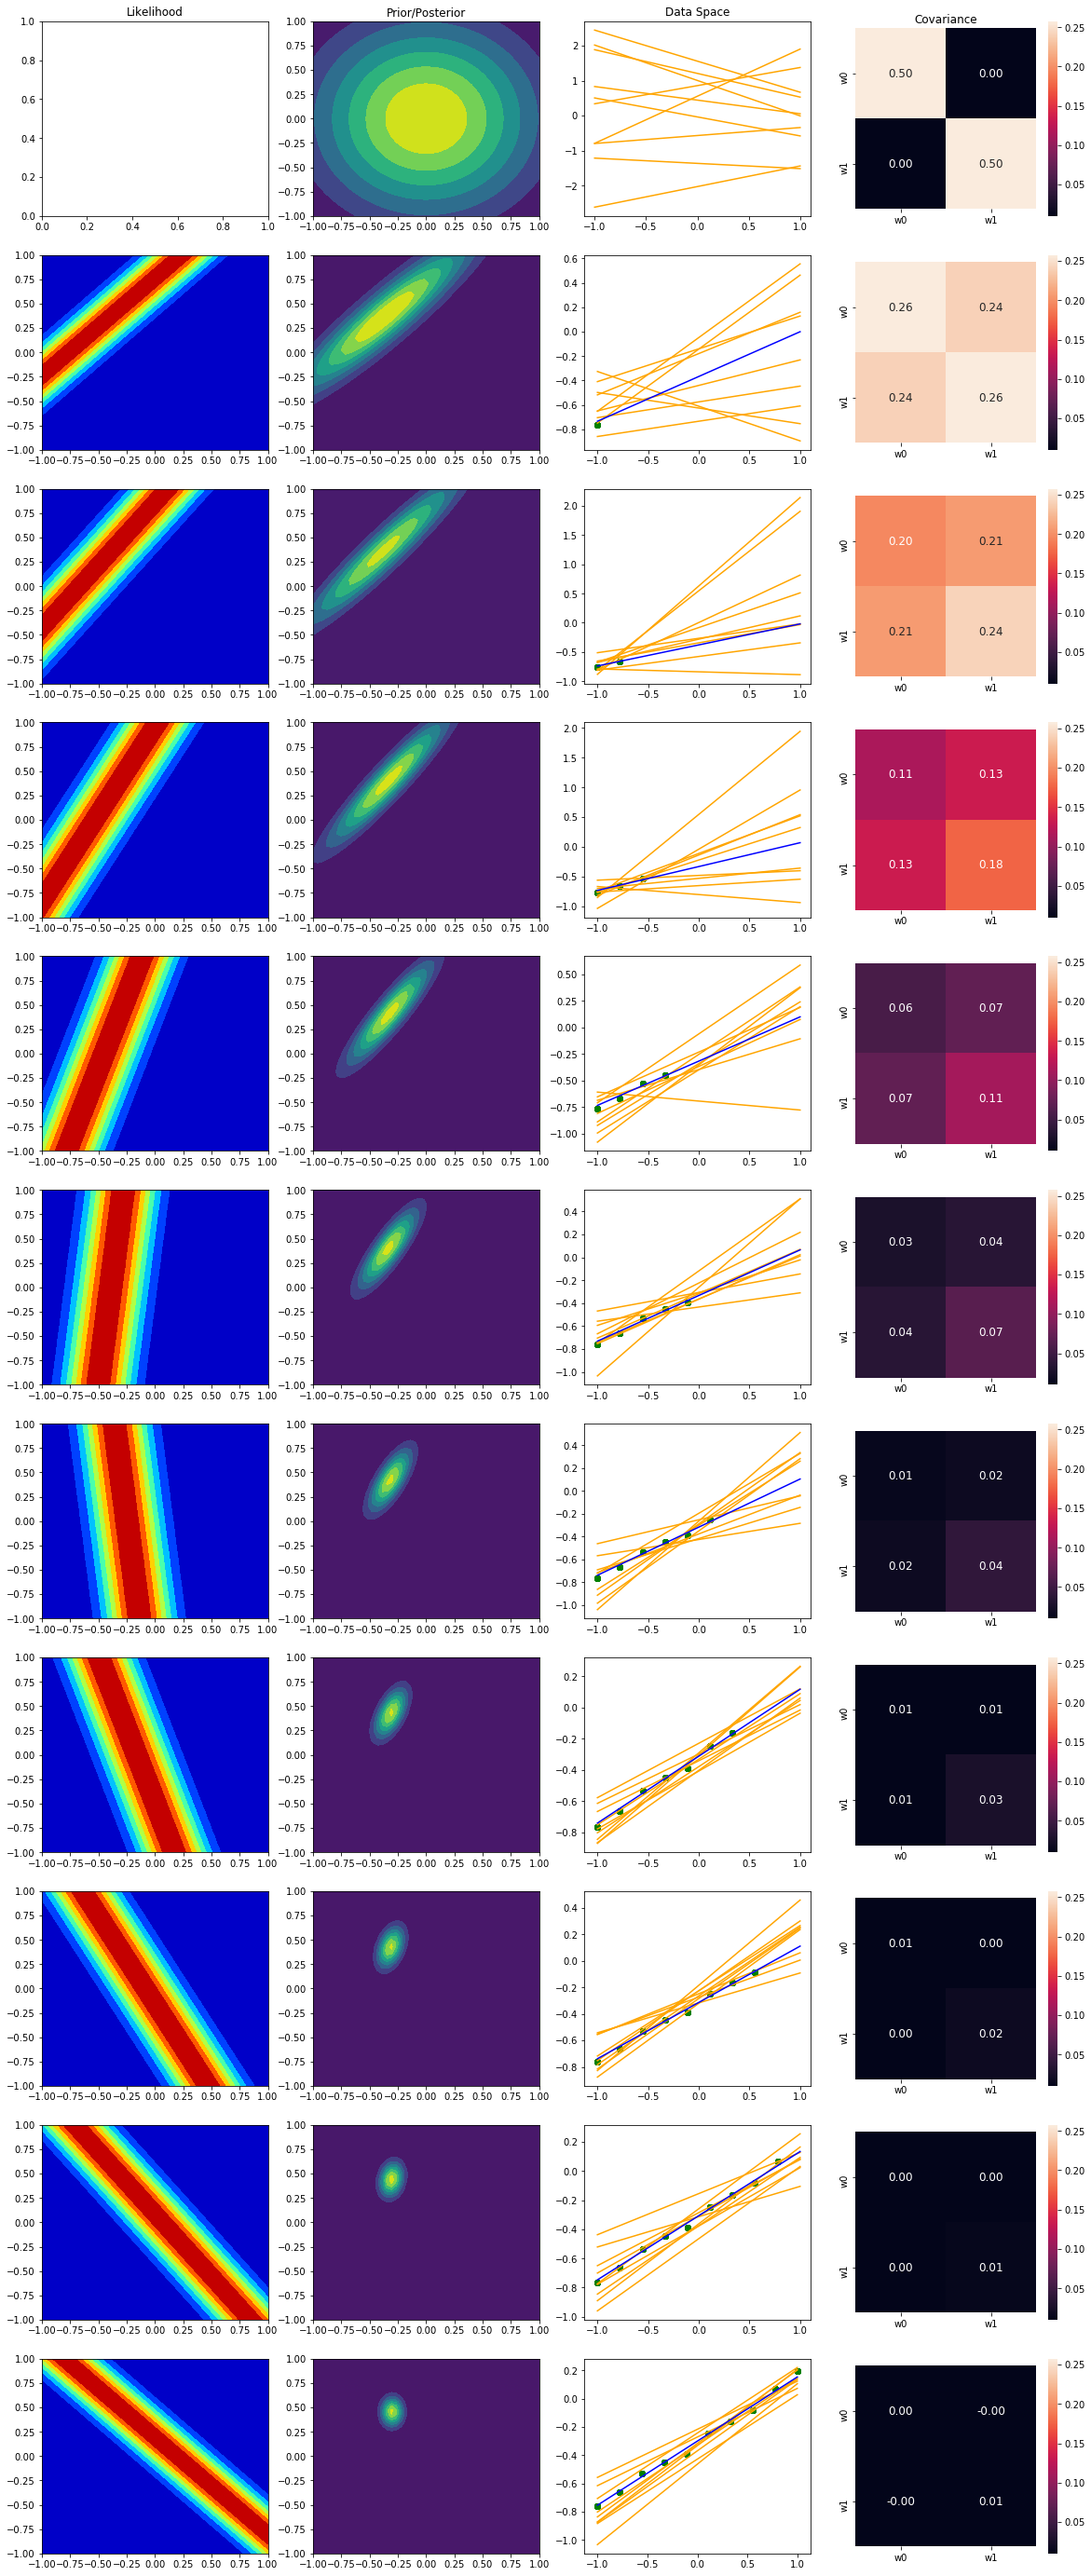

In [9]:
sn_array = []
sn0_ax = np.zeros((2, 2))
sn1_ax = np.zeros((2, 2))
cols = ['w0', 'w1']
fig, ax = plt.subplots(11, 4, figsize=(20, 50))

alpha = 1/prior_var
mn =np.array([0, 0])
sn = np.eye(2)/alpha
sn_array.append(sn)
phi_array = [[1, x] for x in X]
t_array = [y for y in Y]
beta = 1/pow(noise_std_dev,2)
x_input = X
titles = ['Likelihood', 'Prior/Posterior', 'Data Space', 'Covariance']
for ax0, title in zip(ax[0], titles):
    ax0.set_title(title)
for i in range(11):
    if(i!=0):
        phi= phi_array[i-1]
        t = [t_array[i-1]]
        mn, sn = posterior_mean_cov(mn, sn, phi, beta, t)
        mn = list(mn.reshape(1, 2)[0])
        x, y = np.random.multivariate_normal(mn, sn, 9).T
        for w0, w1 in zip(x, y):
            ax[i, 2].plot(x_input, w1*x_input+float(w0), color='orange')
            ax[i, 2].scatter(X[:i], Y[:i], color='green')
        ax[i, 2].plot(x_input, mn[1]*x_input + mn[0], color='blue')
        likelihood_mesh = likelihood_calc(w0_ax, w1_ax, n, X[i-1], Y[i-1])
        posterior_mesh = posterior_calc(likelihood_mesh, prior_mesh)
        ax[i, 0].contourf(w0_ax, w1_ax,  likelihood_mesh, cmap = 'jet')
        sn_array.append(sn)
        sns.heatmap(sn_array[i],
                    cbar=True,
                    annot=True,
                    square=True,
                    robust=True,
                    vmin = 0.010,
                    vmax = 0.2575,
                    fmt='.2f',
                    annot_kws={'size': 12},
                    yticklabels=cols,
                    xticklabels=cols,
                    ax = ax[i, 3])
        ax[i, 1].contourf(sn0_ax, sn1_ax, sn)
        ax[i, 1].contourf(w0_ax, w1_ax, posterior_mesh)
        prior_mesh = posterior_mesh
    else:
        ax[i, 1].contourf(w0_ax, w1_ax, prior_mesh)
        x, y = np.random.multivariate_normal(mn, sn, 10).T
        for w0, w1 in zip(x, y):
            ax[i, 2].plot(x_input, w1*x_input+float(w0), color='Orange')
            ax[i, 2].scatter(X[:i], Y[:i], color='blue')
        sns.heatmap(sn_array[i],
                    cbar=True,
                    annot=True,
                    square=True,
                    robust=True,
                    vmin = 0.010,
                    vmax = 0.2575,
                    fmt='.2f',
                    annot_kws={'size': 12},
                    yticklabels=cols,
                    xticklabels=cols,
                    ax = ax[i, 3])
plt.savefig("bayesian_linear_regression.png")
plt.show()